<a href="https://colab.research.google.com/github/Oksana0020/DL-with-PyTorch/blob/main/Lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Create and Train a Baseline Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform: convert to tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download/load MNIST
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 140MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 11.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 122MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.14MB/s]



--- Training Baseline Model ---
Epoch 1/10, Train Loss: 0.1653
Epoch 2/10, Train Loss: 0.0459
Epoch 3/10, Train Loss: 0.0316
Epoch 4/10, Train Loss: 0.0231
Epoch 5/10, Train Loss: 0.0175
Epoch 6/10, Train Loss: 0.0150
Epoch 7/10, Train Loss: 0.0116
Epoch 8/10, Train Loss: 0.0086
Epoch 9/10, Train Loss: 0.0092
Epoch 10/10, Train Loss: 0.0069
Test Loss: 0.0391, Accuracy: 99.07%


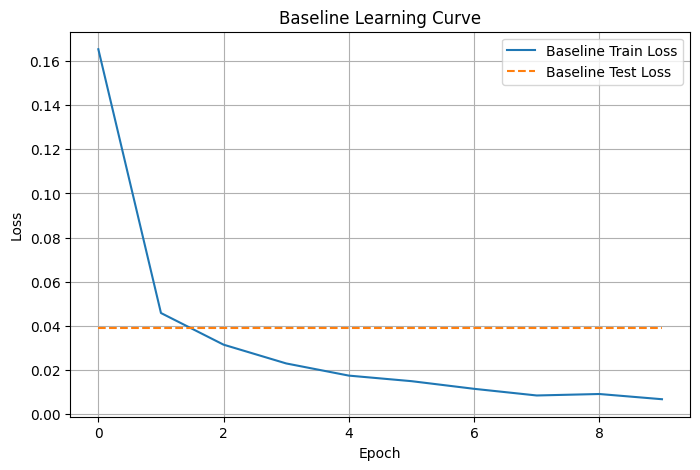

In [ ]:
# Define a simple CNN model class
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define training and evaluation functions

def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")
    return train_losses

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

# Train and evaluate the baseline model
baseline_model = BaselineModel().to(device)
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("\n--- Training Baseline Model ---")
baseline_train_losses = train(baseline_model, train_loader, baseline_optimizer, criterion, epochs=10)
baseline_test_loss, baseline_accuracy = evaluate(baseline_model, test_loader, criterion)

# Plot learning curve for the baseline model
def plot_learning_curves(train_losses, test_loss, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label=f'{model_name} Train Loss')
    plt.plot([test_loss] * len(train_losses), linestyle='--', label=f'{model_name} Test Loss')
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(baseline_train_losses, baseline_test_loss, "Baseline")

# Task 2: Implement Dropout


--- Training Dropout Model ---
Epoch 1/10, Train Loss: 0.2618
Epoch 2/10, Train Loss: 0.0962
Epoch 3/10, Train Loss: 0.0733
Epoch 4/10, Train Loss: 0.0630
Epoch 5/10, Train Loss: 0.0509
Epoch 6/10, Train Loss: 0.0459
Epoch 7/10, Train Loss: 0.0400
Epoch 8/10, Train Loss: 0.0350
Epoch 9/10, Train Loss: 0.0333
Epoch 10/10, Train Loss: 0.0277
Test Loss: 0.0316, Accuracy: 99.17%


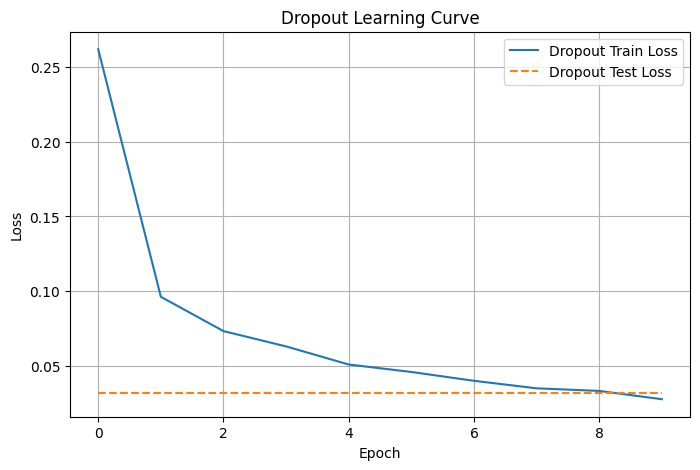

In [ ]:
# Define CNN model with dropout
class DropoutModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DropoutModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

# Train and evaluate dropout model
dropout_model = DropoutModel(dropout_rate=0.5).to(device)
dropout_optimizer = optim.Adam(dropout_model.parameters(), lr=0.001)

print("\n--- Training Dropout Model ---")
dropout_train_losses = train(dropout_model, train_loader, dropout_optimizer, criterion, epochs=10)
dropout_test_loss, dropout_accuracy = evaluate(dropout_model, test_loader, criterion)

plot_learning_curves(dropout_train_losses, dropout_test_loss, "Dropout")


# Task 3: Apply Weight Decay



--- Training Weight Decay Model ---
Epoch 1/10, Train Loss: 0.1565
Epoch 2/10, Train Loss: 0.0477
Epoch 3/10, Train Loss: 0.0338
Epoch 4/10, Train Loss: 0.0259
Epoch 5/10, Train Loss: 0.0223
Epoch 6/10, Train Loss: 0.0183
Epoch 7/10, Train Loss: 0.0153
Epoch 8/10, Train Loss: 0.0148
Epoch 9/10, Train Loss: 0.0121
Epoch 10/10, Train Loss: 0.0120
Test Loss: 0.0260, Accuracy: 99.24%


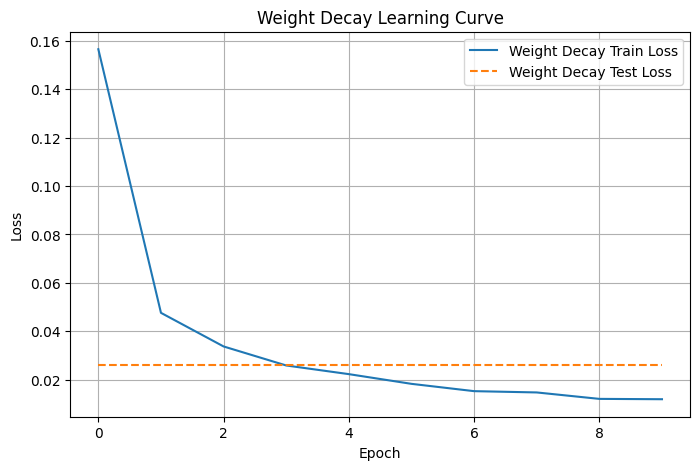

In [ ]:
# Instantiate baseline model architecture again
weightdecay_model = BaselineModel().to(device)
# Define optimizer with weight decay
weightdecay_optimizer = optim.Adam(weightdecay_model.parameters(), lr=0.001, weight_decay=1e-4)

# Train and evaluate model with weight decay
print("\n--- Training Weight Decay Model ---")
weightdecay_train_losses = train(weightdecay_model, train_loader, weightdecay_optimizer, criterion, epochs=10)
weightdecay_test_loss, weightdecay_accuracy = evaluate(weightdecay_model, test_loader, criterion)

plot_learning_curves(weightdecay_train_losses, weightdecay_test_loss, "Weight Decay")

# Task 4: Implement Batch Normalization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu



--- Training BatchNorm Model ---
Epoch 1/10, Train Loss: 0.0984
Epoch 2/10, Train Loss: 0.0358
Epoch 3/10, Train Loss: 0.0243
Epoch 4/10, Train Loss: 0.0188
Epoch 5/10, Train Loss: 0.0134
Epoch 6/10, Train Loss: 0.0114
Epoch 7/10, Train Loss: 0.0096
Epoch 8/10, Train Loss: 0.0068
Epoch 9/10, Train Loss: 0.0078
Epoch 10/10, Train Loss: 0.0055
Test Loss: 0.0277, Accuracy: 99.18%


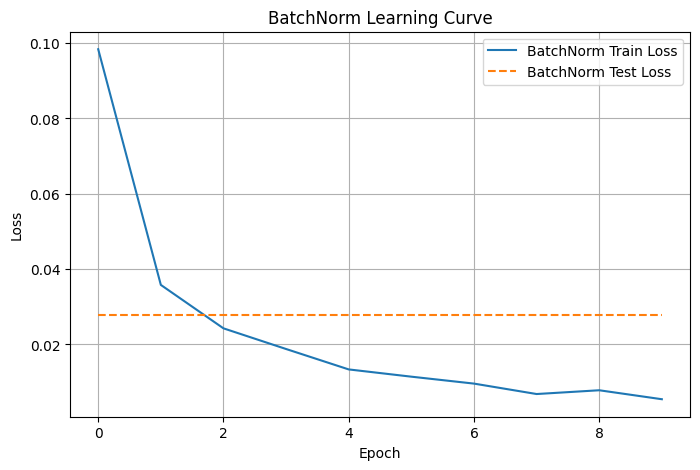


--- Final Test Accuracies ---
Baseline: 99.07%
Dropout: 99.17%
Weight Decay: 99.24%
BatchNorm: 99.18%


In [ ]:
# Define CNN model with batch normalization
class BatchNormModel(nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Train and evaluate batch normalization model
batchnorm_model = BatchNormModel().to(device)
batchnorm_optimizer = optim.Adam(batchnorm_model.parameters(), lr=0.0015)

print("\n--- Training BatchNorm Model ---")
batchnorm_train_losses = train(batchnorm_model, train_loader, batchnorm_optimizer, criterion, epochs=10)
batchnorm_test_loss, batchnorm_accuracy = evaluate(batchnorm_model, test_loader, criterion)

plot_learning_curves(batchnorm_train_losses, batchnorm_test_loss, "BatchNorm")

# --- Final Comparison of All Models ---
print("\n--- Final Test Accuracies ---")
print(f"Baseline: {baseline_accuracy:.2f}%")
print(f"Dropout: {dropout_accuracy:.2f}%")
print(f"Weight Decay: {weightdecay_accuracy:.2f}%")
print(f"BatchNorm: {batchnorm_accuracy:.2f}%")